In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from src.utils import object_to_markdown
from src.inference import MonteCarloInference
from src.samplers import Hamiltonian, MetropolisHastings
from torch import nn
from src.models.toy import PolynomialToyModel, NetToyModel
import pandas as pd

sns.set_style("whitegrid")
sns.set_palette("deep")

First model is a simple polynomial model with:
$$
y | \theta, x \sim \mathcal N(a + bx + cx^2..., \sigma)
$$
where $\sigma$ is known.  Below, a model is defined using known coefficients, and the coefficents are afterward drawn from a normal distribution

In [2]:
torch.manual_seed(123)
true_coeffs = torch.tensor([1.0, 2.0, 0.0, -1.0])

with torch.no_grad():
    toy_model = PolynomialToyModel(true_coeffs)
    toy_data = toy_model.generate_data(n=50)   
    toy_model.coeffs.normal_()

toy_data_train, toy_data_test = torch.utils.data.random_split(toy_data, [30, 20])

This results in the following generated data

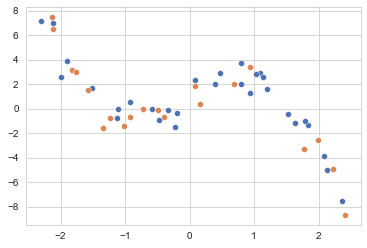

In [3]:
x_train, y_train = toy_data_train[:]
x_test, y_test = toy_data_test[:]
sns.scatterplot(x=x_train, y=y_train)
sns.scatterplot(x=x_test, y=y_test)
plt.show()

The training API has been implemented using an inference object that takes a sampler eg. Hamiltonian MC as argument. 

In [4]:
sampler = Hamiltonian(step_size=0.04)
inference = MonteCarloInference(sampler=sampler)
inference.fit(toy_model, toy_data, burn_in=1000, n_samples=100)

Sampling: 100%|██████████| 100/100 [00:00<00:00, 267.72it/s]


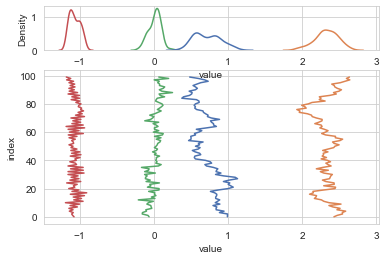

In [5]:
sample_df = pd.DataFrame({f"$c_{i}$" : c for i, c in enumerate(inference.samples_.T)})
plot_data = sample_df.reset_index().melt(id_vars="index")
fig = plt.figure()
grid_spec = fig.add_gridspec(2, 1, height_ratios=(2, 7))

ax_line = fig.add_subplot(grid_spec[1, 0])
ax_marg = fig.add_subplot(grid_spec[0, 0], sharex=ax_line)

sns.lineplot(x = "value", y="index", hue="variable", ax=ax_line, data=plot_data, sort=False, legend=False)
sns.kdeplot(x = "value", hue="variable", data=plot_data, legend=False)

plt.show()

Seems reasonable?

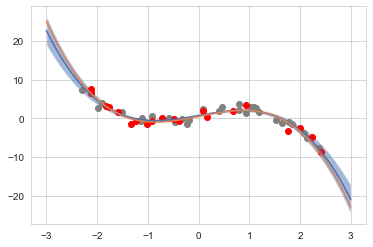

In [7]:
import numpy as np

xs = torch.linspace(-3, 3, 100)
ys = inference.predictive(xs)

ys_mean = ys.mean(0)
ys_std = ys.std(0)

plt.plot(xs, ys_mean)
plt.fill_between(xs, ys_mean - 1.96 * ys_std, ys_mean + 1.96 * ys_std, alpha = 0.5)

toy_model.update_theta(true_coeffs)
plt.plot(xs, toy_model(xs).detach())

plt.scatter(x_train, y_train, color="grey")
plt.scatter(x_test, y_test, color="red")

plt.show()